In [3]:
import cv2
import tifffile
import skimage
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon


In [4]:
def show_comparison(HR, LR, Mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(HR, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('High res')
    
    axes[1].imshow(LR, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(' Low res')
    
    axes[2].imshow(Mask, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('Mask')


In [5]:
def show_histograms(HR,LR):
    plt.hist(HR.ravel(), alpha = 0.6, color = 'red', label = 'High res',bins=10)
    plt.hist(LR.ravel(), alpha = 0.6, color = 'blue', label = 'Low res',bins=10)
    plt.legend()
    plt.show()

In [8]:
# Both images are either downsized or upscaled to 60 micron resolution 
high_res = tifffile.imread('data/raw/Downsized_corespoinding_to_60micron_.tif')[8:128,:,:] # 8 frames of missmatch is droped
mask = tifffile.imread('data/raw/Downsized_to_60micron_56_.tif')[8:128,:,:]
low_res = tifffile.imread('data/raw/upsampled_to_60micron_.tif')[:,15:250,5:] # cropping for better initialization 

In [ ]:
n = 0
show_comparison(high_res[n],low_res[n], mask[n] )

In [35]:
def remove_casing (img,threshold, epsilon):

    #Threshholding 
    ret,thresh = cv2.threshold(img,threshold,1,cv2.THRESH_BINARY)
    
    # Finding contours for the thresholded image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    contour = contours[0] #biggest outside contour
    mask = np.zeros_like(img)
    
    #Step_2 removing the Casing
    polygon = Polygon(contour[:, 0, :])

    # Compute offset
    offset_polygon = polygon.buffer(-epsilon)

    # Convert offset polygon to numpy array and draw on image
    points = np.array(offset_polygon.exterior.coords)
    points = np.expand_dims(points.astype(np.int32), axis=1)
    
    cv2.drawContours(mask, [points], -1, 1, -1 )
    
    return mask

In [36]:
def crop_by_border (image,threshold, epsilon):
    
    #removing the noise which exist out of the specimen area
    border_mask = np.zeros_like(image)

    for i in range(border_mask.shape[0]):
        border_mask[i,:,:] = remove_casing(image[i,:,:].astype('uint8'),threshold,epsilon)
    
    masked_image = image * border_mask
    return masked_image


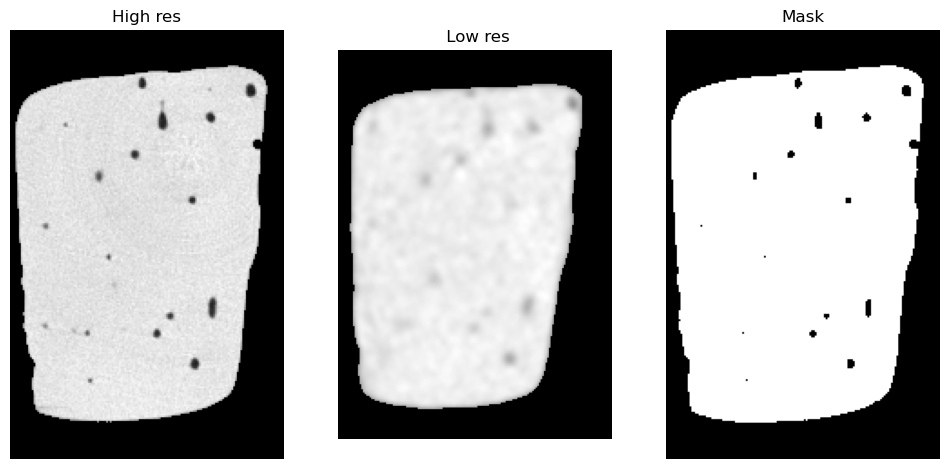

In [37]:
# cropping the cropping by border
cropped_low = crop_by_border(low_res, 100, 0)
cropped_high = crop_by_border(high_res, 100, 0)
show_comparison(cropped_high[n], cropped_low[n], mask[n])

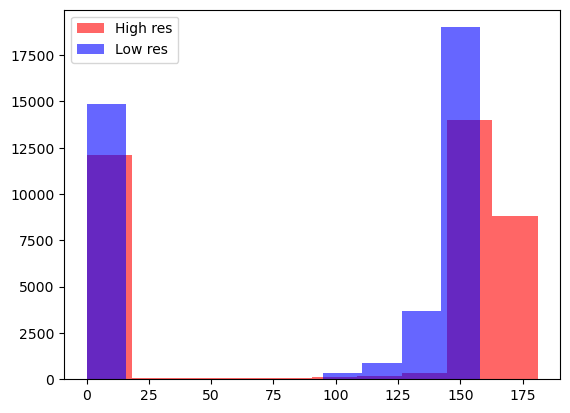

In [38]:
show_histograms(cropped_high[n], cropped_low[n])

In [39]:
def contrast_stretching(input_image):
    # Contrast stretching + Normalizing 0-255
    p2, p98 = np.percentile(input_image, (2, 98))
    stretched_image = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))
    
    stretched_image = cv2.normalize(stretched_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    stretched_image = stretched_image.astype('uint8')
    
    return stretched_image


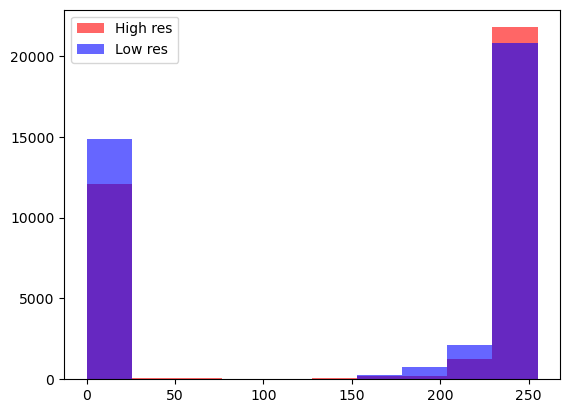

In [40]:
stretched_high = contrast_stretching(cropped_high)
stretched_low = contrast_stretching(cropped_low)
show_histograms(stretched_high[n], stretched_low[n])

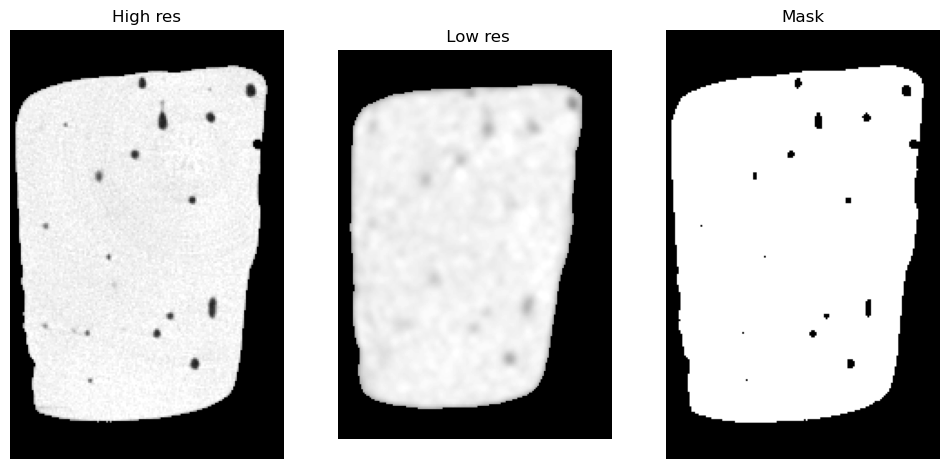

In [41]:
show_comparison(stretched_high[n],stretched_low[n], mask[n] )

In [44]:
# writing the output to tif files 
tifffile.imwrite( 'data/preprocessed/high_res.tif',stretched_high)
tifffile.imwrite( 'data/preprocessed/low_res.tif',stretched_low)
tifffile.imwrite( 'data/preprocessed/mask.tif',mask)